# Pauli Spin Blockade

Using new functions in `august/paul.py` and `august/shfqc.py` to make this notebook easier to work with.


In [2]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [3]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from qcodes import Instrument, Station
from monty import Monty
import MDAC
from may.dots import getvoltages
from may.custom_devices import connect_to_gb, newSiDot
from liveplot import LivePlot
from fridge import Fridge
import paul
from shfqc import SHFQC
from monty import Monty
import time

## Setup

In [5]:
channels = ["ST", "P1", "P2", "J"]
channel_addr = [0, 1, 2, 3]

shfqc = SHFQC(channels, channel_addr, "measure")

In [7]:
shfqc.connect()

try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

lockin = scfg.load_instrument('sr860_top')



gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Connecting to device DEV12158
Creating new command tables
Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.26s
Cannot remove instrument with name sr860_top. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.10s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [8]:
# Disconnect from all devices
disconnect = False
if disconnect:
    shfqc.disconnect()
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("sr860_top")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")

In [9]:
# setup monty
experiment = {
    "desc": "Run detuning and J sweeps to see pauli spin blockade"
}

monty = Monty("rf.psb_better", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 61


### Define parameters

In [15]:
params = {
    "amplitude_volts": {  # define the amplitudes that should be used. (maximum 340mV, give in Volts)
        "mixed_pulse": {  # voltage amplitude for mixed state preperation
            "P1": -0.2,  # make sure keys match drive lines above
            "P2": 0.2,
        },
        "measure_pulse_start": {  # voltages for stepping over when sweeping
            "P1": 0.0,
            "P2": 0.0,
            "J": 0.0,
        },
        "measure_pulse_end": {
            "P1": -0.01,
            "P2": 0.01,
            "J": 0.0,
        },
        "ramp_rate": 13e-5,  # V/sample
    },
    "readout": {
        "freq": 406.6e6,  # (Hz) try 406.2e6
        "gain": 0.95,  # If we set this to 1, then output overloads
        "time": 100e-6,  # sec
    },
    "timings_sec": {  # all in seconds
        "mixed_initilise": 600e-6,
        "read": 100e-6,
        "settle": 3e-3,
        "trigger": 8e-3,  # metronome of the internal trigger
        "buffer": 10e-6,
        "sampling_divider": 6,  # playback waveform resolution 2^X
    },
    "feedback": {
        "target": -24.1,  # in dB
        "stepsize": 2e-2,  # arbitrary units
        "slope": -0,  # -1, 1 depending on slope, 0 to disable feedback
    },
    "powers": {  # in dB presets from UI
        "acq_in": 0,
        "acq_out": -10,
        "drive": 0,  # only 0 is supported
    },
    "averaging": {
        "seqc_averages": 200,  # max 2**19 points
        "num_detuning": 10,
        "num_j": 1,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}


# Dynamic variables
# create arrays of our sweeping paramters
j_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["J"],
                      params["amplitude_volts"]["measure_pulse_end"]["J"],
                      params["averaging"]["num_j"])
p1_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["P1"],
                       params["amplitude_volts"]["measure_pulse_end"]["P1"],
                       params["averaging"]["num_detuning"])
p2_steps = np.linspace(params["amplitude_volts"]["measure_pulse_start"]["P2"],
                       params["amplitude_volts"]["measure_pulse_end"]["P2"],
                       params["averaging"]["num_detuning"])

### Configure device

In [16]:
# setup channels to match parameters
paul.setupchannels(shfqc, params)
paul.setupsequencers(shfqc, params, print_programs=False)
paul.setup_command_tables(shfqc, params)

## Run functions

In [18]:
def sweep_j_and_detuning():
    """2D parameter sweep of J and P1/P2 in detuning setup. Can measure PSB if mixed state preperation amplitude is not zero"""
    monty.newrun("j_and_detuning", params)

    # work out what we should be doing for feedback
    print("Measuring initial feedback point")
    paul.synchchannels(shfqc, [shfqc.qa_channel_name])
    with shfqc.device.set_transaction():
        
        shfqc["measure"].spectroscopy.result.length(1)
        seqc_program_prior_read = f"""
            repeat({params["averaging"]["seqc_averages"]}) {{
                waitDigTrigger(1);
        
                setTrigger(1);
                setTrigger(0);
            }}
            """
        shfqc["measure"].generator.load_sequencer_program(seqc_program_prior_read)
    
    time.sleep(1)
    shfqc["measure"].spectroscopy.result.length.wait_for_state_change(1, timeout=10)  # wait for changes to propagate
    
    data = paul.run_empty_experiment(shfqc)

    # run the real experiment
    paul.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    paul.setupsequencers(shfqc, params, print_programs=False)  # reload original QA code
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_detuning"], 2), dtype=np.complex64)
    st_result = np.zeros(result.shape, dtype=np.float64)
    
    print("Sweeping P1, P2 and J")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #with LivePlot(p1_steps, xlabel="P1 voltage (dV)", ylabel="Amplitude (dB)") as lplot: 
        
        for k, (p1, p2) in enumerate(zip(tqdm(p1_steps, leave=False, desc="Detuning"), p2_steps)):
            paul.movemeasurement(shfqc, p1, p2, j, params)  # Use cmd index = 1
            #st_result[i, k] = paul.calculate_feedback(shfqc, data[-1], params)  # cmd index = 0
            paul.upload_command_tables(shfqc)
            data = paul.run_psb_experiment(shfqc)
            result[i, k] = data
            #lplot.update(autodb(result[i, :, 1]))
        monty.snapshot({"data": result, "st_result": st_result})

    results = {"data": result, "st_result": st_result}
    monty.save(results)
    return results

In [27]:
results = sweep_j_and_detuning()

Started new run j_and_detuning.15
Measuring initial feedback point


Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

1
Sweeping P1, P2 and J


J:   0%|          | 0/1 [00:00<?, ?it/s]

Detuning:   0%|          | 0/10 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Run finished and took 0:00:34.081217.
Saving to j_and_detuning.15.xz
Saving to experiment.yaml


In [66]:
# PLOTTING FUNCTIONS

def plot_res(ref_amp, ref_phase):
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

    ax0.plot(p1_steps, ref_amp[0], ".-", color="steelblue")
    ax1.plot(p1_steps, ref_phase[0], ".-", color="orange",
                label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".reference.1st")
    ax1.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax1.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "reference_1st")

def plot_meas(meas_amp, meas_phase):
    # plot the FIRST measurement point

    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, meas_amp[0], ".-", color="steelblue")
    ax1.plot(p1_steps, meas_phase[0], ".-", color="orange",
            label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".measurement.1st")
    ax1.set_xlabel("P1 voltage")
    
    ax0.grid()
    ax1.grid()
    ax1.legend()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "measurement_1st")

def plot_diff(ref_amp, ref_phase, meas_amp, meas_phase):
    # plot the FIRST localised measurement (mes - ref)

    a = meas_amp[0] - ref_amp[0]
    p = meas_phase[0] - ref_phase[0]
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    
    ax0.plot(p1_steps, a, ".-", color="steelblue")
    ax1.plot(p1_steps, p, ".-", color="orange",
            label = f"P1: {si.P1()}, P2: {si.P2()}")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.identifier + "." + monty.runname + ".difference")
    ax1.set_xlabel("P1 voltage")
    ax0.grid()
    ax1.grid()
    ax1.legend()
    
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()
    
    monty.savefig(plt, "detuning minus ref 1st")

def plot_st_fb(st_result):

    fig, ax = plt.subplots()
    
    ax.plot(p1_steps, st_result[0])
    ax.set_xlabel("P1 voltage (V)")
    ax.set_ylabel("ST amplitude (a.u.)")
    ax.set_title(monty.identifier + "." + monty.runname + ".st")
    plt.tight_layout()
    
    monty.savefig(plt, "st_history")

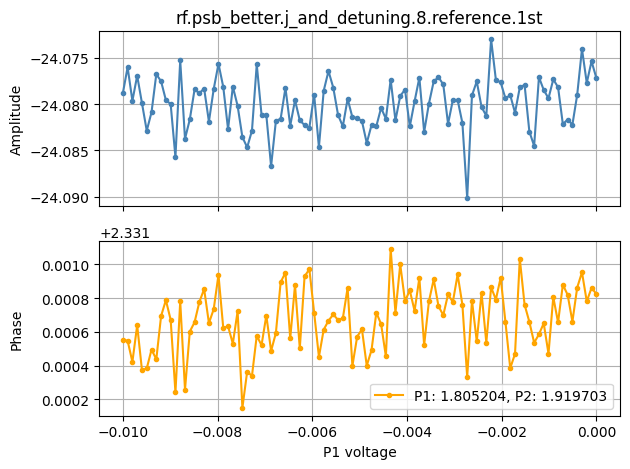

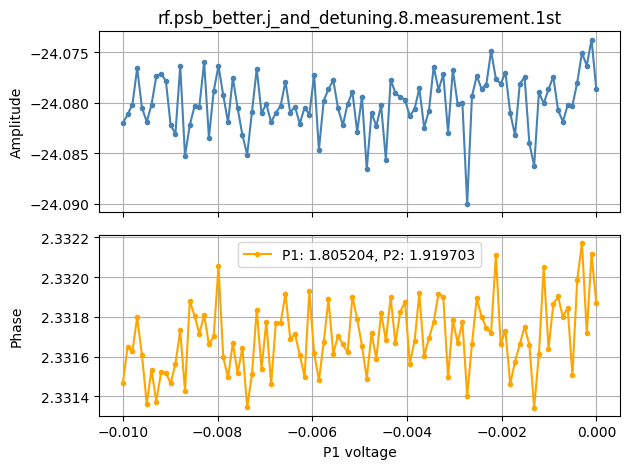

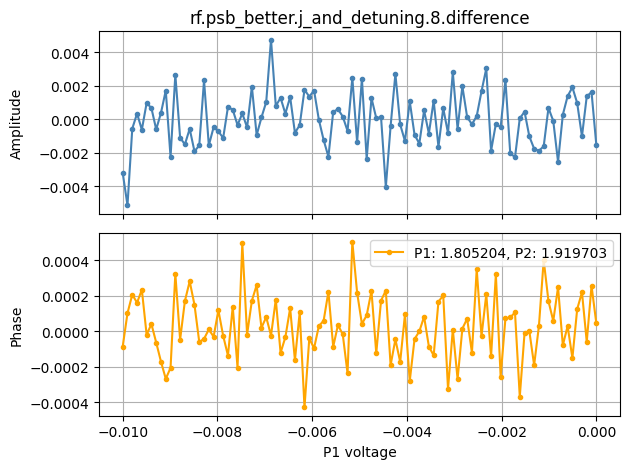

In [76]:
result = results["data"]
ref = result[:, :, 0]
mes = result[:, :, 1]

ref_amp = 10*np.log10(np.abs(ref)**2/50*1000)
ref_phase = np.unwrap(np.angle(ref))  # add axis for unwrap?

meas_amp = 10*np.log10(np.abs(mes)**2/50*1000)
meas_phase = np.unwrap(np.angle(mes))  # add axis for unwrap?

# plot results
plot_res(ref_amp, ref_phase)
plot_meas(meas_amp, meas_phase)
plot_diff(ref_amp, ref_phase, meas_amp, meas_phase)